In [1]:
# Module: packages.py
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from PIL import Image
import os
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt


In [2]:
# Pfade zu den Daten
image_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'
excel_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser.xlsx'

In [3]:


def load_data(image_dir, excel_path, target_size=(196, 256)):  # Zielgröße anpassen
    # Lade die Excel-Datei
    df = pd.read_excel(excel_path)
    
    # Stelle sicher, dass die Spalte 'mittlerer_durchmesser' vorhanden ist
    if 'mittlerer_durchmesser' not in df.columns:
        raise ValueError("Die Excel-Datei muss eine Spalte 'mittlerer_durchmesser' enthalten.")
    
    # Lade die Bilder und die entsprechenden Durchmesser
    image_paths = [os.path.join(image_dir, img) for img in sorted(os.listdir(image_dir))]

    # Stelle sicher, dass die Anzahl der Bilder mit der Anzahl der Einträge in der Excel-Datei übereinstimmt
    assert len(image_paths) == len(df), "Anzahl der Bilder und Durchmesser stimmt nicht überein."
    
    # Lade die Bilder in eine Liste und skaliere sie auf target_size
    images = []
    for img_path in image_paths:
        try:
            with Image.open(img_path) as img:
                img = img.convert('L')  # Konvertiere in Graustufen
                img = img.resize(target_size)  # Resize auf die Zielgröße
                images.append(np.array(img, dtype=np.float32))  # Konvertiere zu float32
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            continue

    diameters = df['mittlerer_durchmesser'].values
    
    # Konvertiere die Listen zu NumPy-Arrays
    images = np.array(images)
    diameters = np.array(diameters, dtype=np.float32)  # Konvertiere zu float32
    
    # Normalisierung der Bilder
    images /= 255.0
    
    # Füge die Kanal-Dimension hinzu
    if len(images.shape) == 3:
        images = images[..., np.newaxis]  # Hinzufügen der Kanal-Dimension
    
    # Aufteilen in Trainings- und Testdaten
    X_train, X_test, y_train, y_test = train_test_split(images, diameters, test_size=0.15, random_state=44)
    
    # Debugging: Form der Arrays überprüfen
    print("Shape von X_train:", X_train.shape)
    print("Shape von X_test:", X_test.shape)
    print("Shape von y_train:", y_train.shape)
    print("Shape von y_test:", y_test.shape)
    
    return X_train, X_test, y_train, y_test


In [4]:
#val loss 9,3 für das folgende modell, best so far
# Module: model.py
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

def build_and_train_model(X_train, y_train, X_test, y_test, epochs=1000, model_save_path='C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'):
    # Füge eine Dimension für die Kanäle hinzu (falls notwendig)
    if len(X_train.shape) == 3:
        X_train = X_train[..., np.newaxis]
        X_test = X_test[..., np.newaxis]

    model = Sequential([
        # Erste Convolutional Schicht
        Conv2D(128, (3, 3), activation='relu', input_shape=(196, 256, 1)),
        MaxPooling2D((2, 2)),
        
        # Zweite Convolutional Schicht
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Dritte Convolutional Schicht
        Conv2D(256, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Vierte Convolutional Schicht
        Conv2D(512, (5, 5), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Fünfte Convolutional Schicht (optional)
        Conv2D(1024, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        

        # Flatten-Schicht
        Flatten(),
        
        # Dense Schicht
        Dense(256, activation='relu'),
        Dropout(0.4),
        
        # Output-Schicht
        Dense(1)
    ])

    # Kompiliere das Modell
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5)
    
    # Trainiere das Modell
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=16, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

    # Speichern des Modells
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")
    
    return model, history


In [5]:
# Module: evaluation.py


def load_trained_model(model_save_path):
    # Modell laden
    model = load_model(model_save_path)
    return model

def evaluate_model(model_path, X_test, y_test):
    # Modell laden
    try:
        model = load_model(model_path)
        print("Model successfully loaded.")
    except Exception as e:
        print(f"Error loading model: {e}")
        return

    # Überprüfen Sie die Eingabeformate
    print("Shape von X_test beim Modellbewerten:", X_test.shape)
    print("Shape von y_test beim Modellbewerten:", y_test.shape)

    # Model evaluieren
    try:
        loss = model.evaluate(X_test, y_test)
        print(f"Test loss: {loss}")
    except Exception as e:
        print(f"Error evaluating model: {e}")

    # Trainings- und Validierungsverlust plotten
    try:
        plt.plot(history.history['loss'], label='train_loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    except Exception as e:
        print(f"Error plotting history: {e}")



Shape von X_train: (303, 256, 196, 1)
Shape von X_test: (54, 256, 196, 1)
Shape von y_train: (303,)
Shape von y_test: (54,)
Shape von X_train vor dem Training: (303, 256, 196, 1)
Shape von X_test vor dem Training: (54, 256, 196, 1)
Epoch 1/1000


c:\Users\chris\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 190.8719 - val_loss: 125.2084 - learning_rate: 1.0000e-04
Epoch 2/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 106.3435 - val_loss: 76.2427 - learning_rate: 1.0000e-04
Epoch 3/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 77.0697 - val_loss: 63.6944 - learning_rate: 1.0000e-04
Epoch 4/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 68.9633 - val_loss: 44.9572 - learning_rate: 1.0000e-04
Epoch 5/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 40.3776 - val_loss: 15.6614 - learning_rate: 1.0000e-04
Epoch 6/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 21.6809 - val_loss: 11.1001 - learning_rate: 1.0000e-04
Epoch 7/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 20.4802 - val_loss: 29.6734 - learning_rate: 1.0000e-04
Epoch 8/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 30.9868 - val_loss: 22.4058 - learning_rate: 1.0000e-04
Epoch 9/1000
19/19 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - loss: 22.3395 - val_loss: 9.

Model saved to C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5
Model successfully loaded.
Shape von X_test beim Modellbewerten: (54, 256, 196, 1)
Shape von y_test beim Modellbewerten: (54,)
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step - loss: 8.5090
Test loss: 8.466798782348633


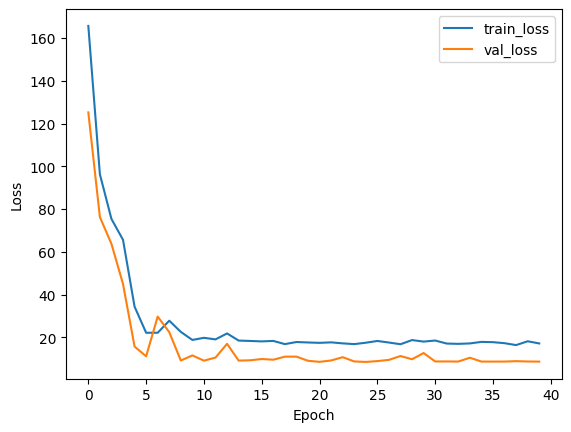

In [6]:


# Daten laden
X_train, X_test, y_train, y_test = load_data(image_dir, excel_path)

# Debugging: Überprüfen der Shapes vor dem Training
print("Shape von X_train vor dem Training:", X_train.shape)
print("Shape von X_test vor dem Training:", X_test.shape)

# Modell erstellen und trainieren
model, history = build_and_train_model(X_train, y_train, X_test, y_test, epochs=1000, model_save_path='C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5')

# Modell bewerten
evaluate_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5', X_test, y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━

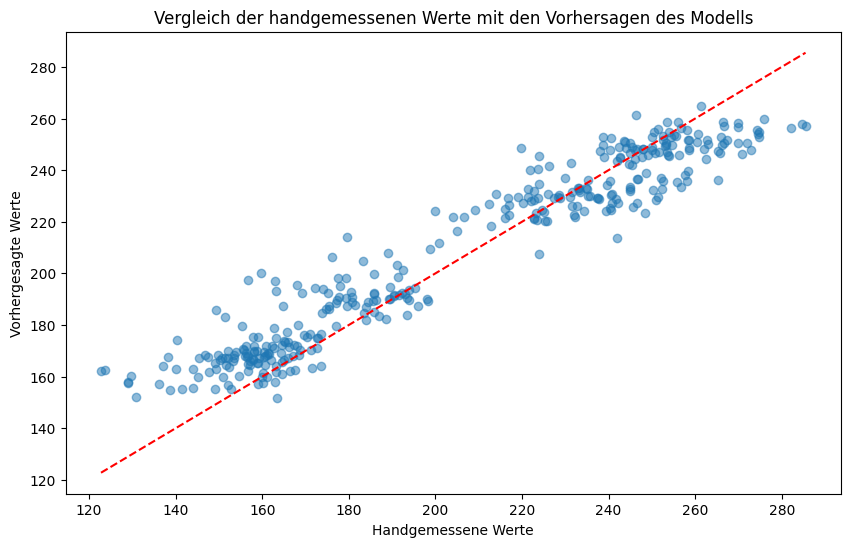

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import os

# Pfade zu den Daten und zum Modell
image_folder_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'
manual_data_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser neu.xlsx'
model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'

def load_data(image_folder_path, excel_path):
    # Liste der Bilder im Ordner (wir nehmen an, sie sind bereits sortiert)
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    
    # Überprüfen, ob Bilder vorhanden sind
    if len(image_files) == 0:
        raise ValueError("Keine Bilddateien gefunden. Überprüfe den Pfad und das Verzeichnis.")
    
    # Lade und normalisiere die Bilder
    images = []
    for image_file in image_files:
        image_path = os.path.join(image_folder_path, image_file)
        img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
        img_array = img_to_array(img)
        images.append(img_array)
    
    X = np.array(images)
    
    # Lade die handgemessenen Daten
    manual_data = pd.read_excel(excel_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen, ob die Anzahl der Bilder mit den handgemessenen Werten übereinstimmt
    if len(image_files) != len(manual_measurements):
        raise ValueError("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")
    
    y = np.array(manual_measurements)
    
    # Aufteilung der Daten in Trainings- und Testsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return prediction[0][0]

def evaluate_model2(model_path, image_folder_path, manual_data_path):
    # Modell laden
    model = load_model(model_path)

    # Daten laden
    X_train, X_test, y_train, y_test = load_data(image_folder_path, manual_data_path)

    # Vorhersagen für alle Bilder im Testset
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    predictions = [predict_image(os.path.join(image_folder_path, image_file), model) for image_file in image_files]
    predictions = np.array(predictions)
    
    # Vorhersagen für das Testset
    y_test_predictions = model.predict(X_test)

    # Die erste Spalte als handgemessene Werte verwenden
    manual_data = pd.read_excel(manual_data_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values

    # Überprüfen der Anzahl der Bilder und der Anzahl der handgemessenen Werte
    print(f"Anzahl der Bilder: {len(predictions)}")
    print(f"Anzahl der handgemessenen Werte: {len(manual_measurements)}")

    # Wenn die Anzahl der Vorhersagen und der manuellen Werte übereinstimmt
    if len(predictions) == len(manual_measurements):
        # Scatterplot erstellen
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_measurements, predictions, alpha=0.5)
        plt.xlabel('Handgemessene Werte')
        plt.ylabel('Vorhergesagte Werte')
        plt.title('Vergleich der handgemessenen Werte mit den Vorhersagen des Modells')
        plt.plot([min(manual_measurements), max(manual_measurements)], [min(manual_measurements), max(manual_measurements)], color='red', linestyle='--')
        plt.show()
    else:
        print("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")

# Modell bewerten
evaluate_model2(model_path, image_folder_path, manual_data_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━

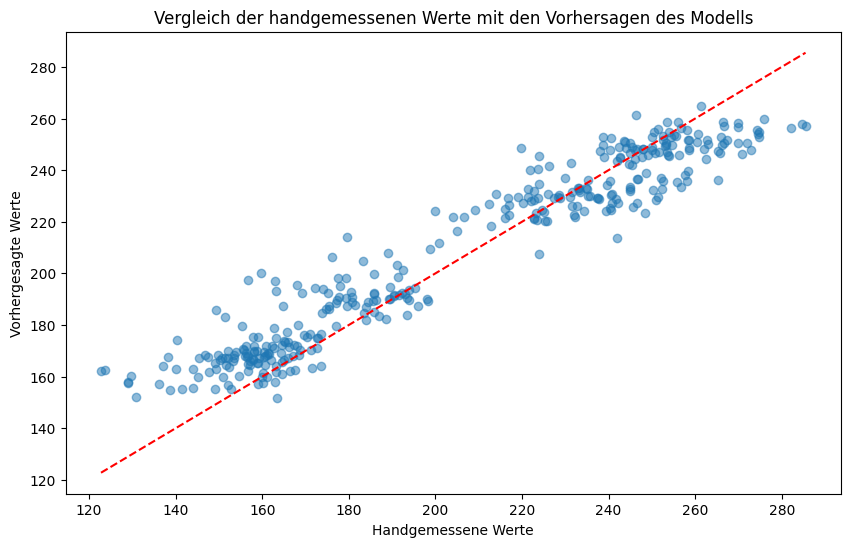

Durchschnittliche Abweichung (MAE): 10.697593361840179
R²-Wert: 0.8964943704397842


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import os

# Pfade zu den Daten und zum Modell
image_folder_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/preprocessed_images/'
manual_data_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Sphäroide BA/gemessene Durchmesser.xlsx'
model_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/bilder_und_durchmesser_1.h5'

def load_data(image_folder_path, excel_path):
    # Liste der Bilder im Ordner (wir nehmen an, sie sind bereits sortiert)
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    
    # Überprüfen, ob Bilder vorhanden sind
    if len(image_files) == 0:
        raise ValueError("Keine Bilddateien gefunden. Überprüfe den Pfad und das Verzeichnis.")
    
    # Lade und normalisiere die Bilder
    images = []
    for image_file in image_files:
        image_path = os.path.join(image_folder_path, image_file)
        img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
        img_array = img_to_array(img)
        images.append(img_array)
    
    X = np.array(images)
    
    # Lade die handgemessenen Daten
    manual_data = pd.read_excel(excel_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen, ob die Anzahl der Bilder mit den handgemessenen Werten übereinstimmt
    if len(image_files) != len(manual_measurements):
        raise ValueError("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")
    
    y = np.array(manual_measurements)
    
    # Aufteilung der Daten in Trainings- und Testsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(256, 196), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  # Normalisiere das Bild
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return prediction[0][0]

def evaluate_model(model_path, image_folder_path, manual_data_path):
    # Modell laden
    model = load_model(model_path)

    # Daten laden
    X_train, X_test, y_train, y_test = load_data(image_folder_path, manual_data_path)

    # Vorhersagen für alle Bilder im Testset
    image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.tif')]
    predictions = [predict_image(os.path.join(image_folder_path, image_file), model) for image_file in image_files]
    predictions = np.array(predictions)
    
    # Vorhersagen für das Testset
    y_test_predictions = model.predict(X_test).flatten()
    
    # Die erste Spalte als handgemessene Werte verwenden
    manual_data = pd.read_excel(manual_data_path)
    manual_measurements = manual_data.iloc[:, 0].dropna().values
    
    # Überprüfen der Anzahl der Bilder und der Anzahl der handgemessenen Werte
    print(f"Anzahl der Bilder: {len(predictions)}")
    print(f"Anzahl der handgemessenen Werte: {len(manual_measurements)}")

    # Sicherstellen, dass die Anzahl der Vorhersagen mit der Anzahl der Testwerte übereinstimmt
    if len(predictions) == len(manual_measurements):
        # Scatterplot erstellen
        plt.figure(figsize=(10, 6))
        plt.scatter(manual_measurements, predictions, alpha=0.5)
        plt.xlabel('Handgemessene Werte')
        plt.ylabel('Vorhergesagte Werte')
        plt.title('Vergleich der handgemessenen Werte mit den Vorhersagen des Modells')
        plt.plot([min(manual_measurements), max(manual_measurements)], [min(manual_measurements), max(manual_measurements)], color='red', linestyle='--')
        plt.show()

        # Berechnung der Metriken
        mae = mean_absolute_error(manual_measurements, predictions)
        r2 = r2_score(manual_measurements, predictions)
        
        # Ausgabe der Metriken
        print(f"Durchschnittliche Abweichung (MAE): {mae}")
        print(f"R²-Wert: {r2}")
    else:
        print("Die Anzahl der Bilder stimmt nicht mit der Anzahl der handgemessenen Werte überein.")

# Modell bewerten
evaluate_model(model_path, image_folder_path, manual_data_path)
